# Part 1: Exploring Cook County Housing

## 1. Introduction

This project explores insights from a comprehensive housing dataset embedded within the dense social context of Cook County, Illinois.

Part 1 focuses on basic Exploratory Data Analysis (EDA) to understand the structure of the data. Additionally, new features are added to the dataset while cleaning the data in the process.

In [1]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# 2. Data Description

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is `Sale Price`, which will be projected with linear regression.

The dataset is split into two parts:
- **Training/Validation Set**: Contains 204,792 observations, used for data analysis and model training.
- **Test Set**: Contains 68,264 observations, used for evaluating the model. Notably, the test set does not include values for the target variable, `Sale Price`.

A more detailed explanation of each feature can be found in the `codebook.txt` file.



In [2]:
with zipfile.ZipFile('data/cook_county_data.zip') as item:
    item.extractall()

training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

For Part 1 of this analysis, only the training/validation set is used to perform data cleaning and feature engineering. The following verifies that the data shape matches the description.

In [3]:
# 204,792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

In [4]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

### Contextualizing the Data
- Granularity: Each row represents an individual property sold in Cook County, Illinois.
- The data was likely collected by a real estate agency or assessor's office to analyze market trends and explore how property features influence sale prices.
- It provides valuable information for establishing competitive property prices and helping clients make informed decisions about future real estate purchases in the area.



# 3. Exploratory Data Analysis (EDA)

This dataset was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home. More information about data collection can be found in the CCAO's [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf).

### Sale Price
The following visualizes the distribution and summary statistics of the target variable, `Sale Price`.

In [5]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label],
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3,
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

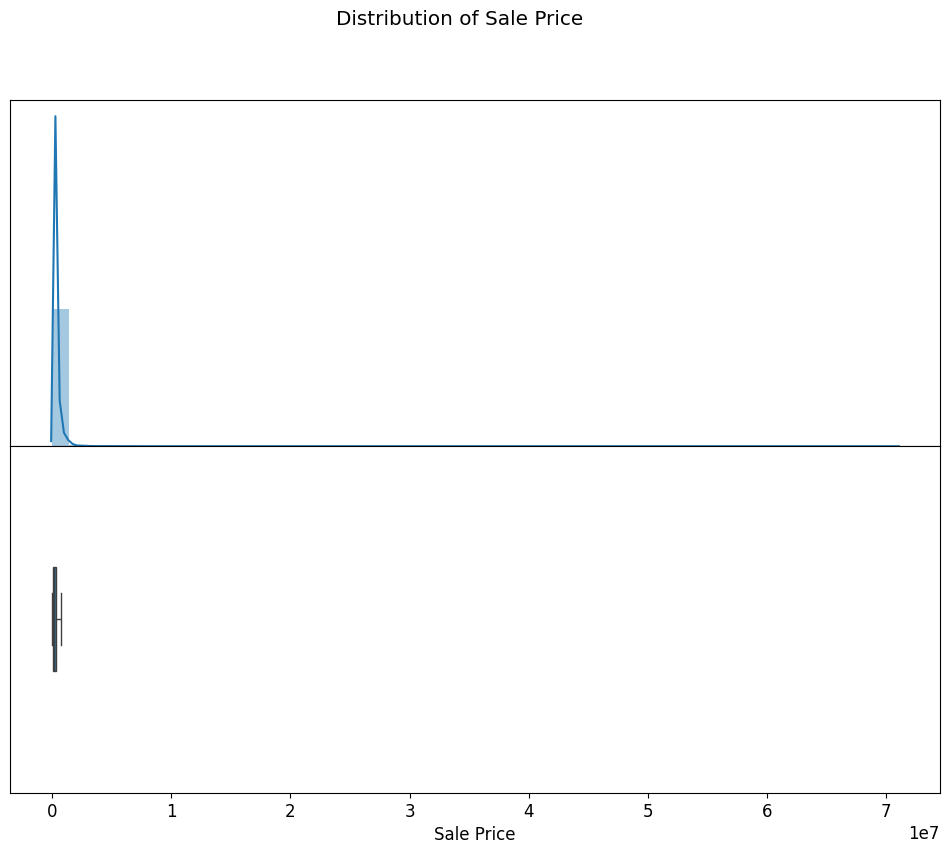

In [6]:
plot_distribution(training_data, label='Sale Price')

In [7]:
training_data['Sale Price'].describe()

,Sale Price
count,2.047920e+05
mean,2.451646e+05
std,3.628694e+05
min,1.000000e+00
25%,4.520000e+04
50%,1.750000e+05
75%,3.120000e+05
max,7.100000e+07


Outliers in the `Sale Price` column distort the scale of the plot, making it difficult to observe key trends in the distribution. A way to overcome this issue is to remove the outliers, which can be identified using the 1.5*IQR formula. Once the outliers are identified, a new `Sale Price` column without outliers can be created and used in a new distribution plot that will be more effective in depicting the distribution of property sale prices.

To better visualize the majority of households, the focus is shifted to a subset of `Sale Price`, with a log transformation applied.
- `training_data` contains only households whose price is at least $500.
- A new column, `Log Sale Price`, is added to `training_data` to store log-transformed sale prices.

The model's target variable will be the log-transformed sale prices from the column `Log Sale Price`.

In [8]:
training_data = training_data[training_data['Sale Price'] >= 500]

training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

The distribution for the Log Scale Price is much more uniform, as shown below.

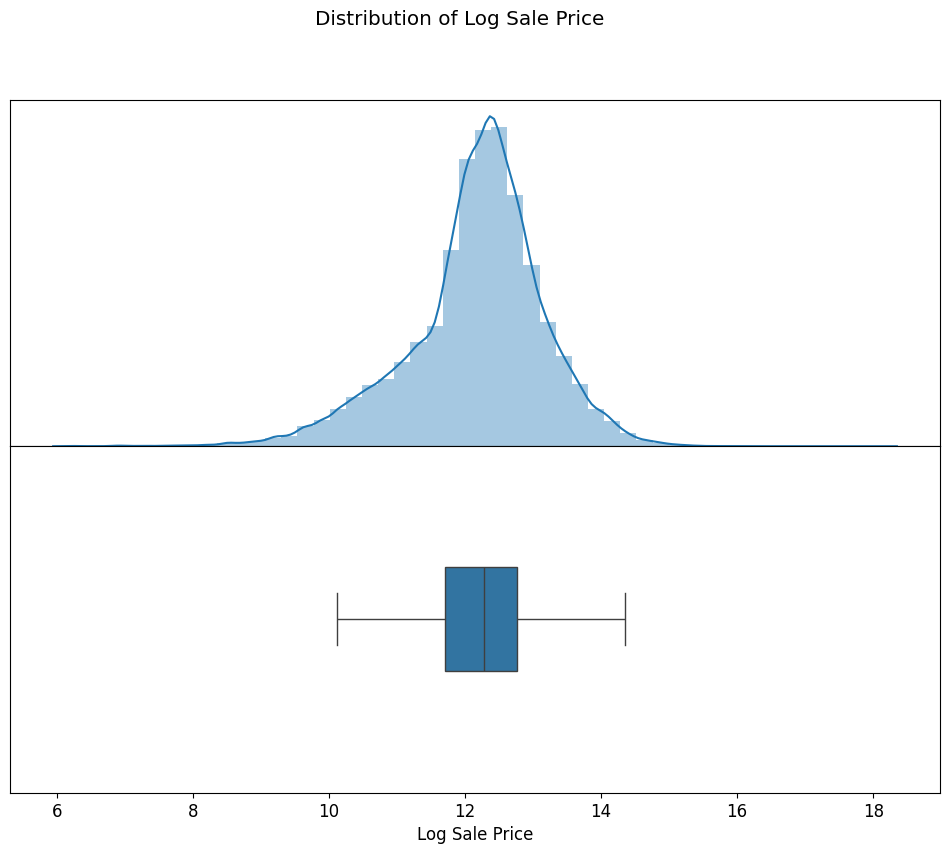

In [9]:
plot_distribution(training_data, label='Log Sale Price');

Next, the correlation between `Log Sale Price` and the total area occupied by the property is explored. Based on the `codebook.txt` file, the column `Building Square Feet` measures "(from the exterior) the total area, in square feet, occupied by the building".

A new column, `Log Building Square Feet`, is added to `training_data` and contains the log-transformed area occupied by each property.

In [10]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

Outliers from the data are addressed by the function `remove_outliers`, which removes outliers based on thresholds. For example, `remove_outliers(training_data, 'Building Square Feet', lower=500, upper=8000)` returns a copy of `data` with only observations that satisfy `Building Square Feet` less than or equal to 8000 (inclusive) and `Building Square Feet` greater than 500 (exclusive).

In [11]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than this will be removed

    Output:
      a DataFrame with outliers removed

    Note: This function should not change mutate the contents of data.
    """
    data = data[data[variable] > lower]
    data = data[data[variable] <= upper]
    return data

# 4. Feature Engineering

### Bedrooms

The total number of bedrooms is extracted as the first feature of the model. The `Bedrooms` column doesn't exist in the original `DataFrame`; it is part of the `Description` column.

The following variables can also be extracted from the `Description` column:

1. The date the property was sold on.
2. The number of stories the property contains.
3. The address of the property.
4. The total number of rooms inside the property.
5. The total number of bedrooms inside the property.
6. The total number of bathrooms inside the property.

The function `add_total_bedrooms(data)` returns a copy of `data` with an additional column called `Bedrooms` that contains the total number of bedrooms (**as integers**) for each house. Missing values are treated as zeros.

In [12]:
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bedrooms" containing ints.

    """
    with_rooms = data.copy()
    with_rooms["Bedrooms"] = with_rooms["Description"].str.extract(r'rooms, (\d) of which are bedrooms').fillna(0).astype(int)
    return with_rooms

training_data = add_total_bedrooms(training_data)

The following visualization highlights the relationship between `Bedrooms` and `Log Sale Price`.

[Text(0.5, 1.0, 'Bedrooms vs. Log Sale Price')]

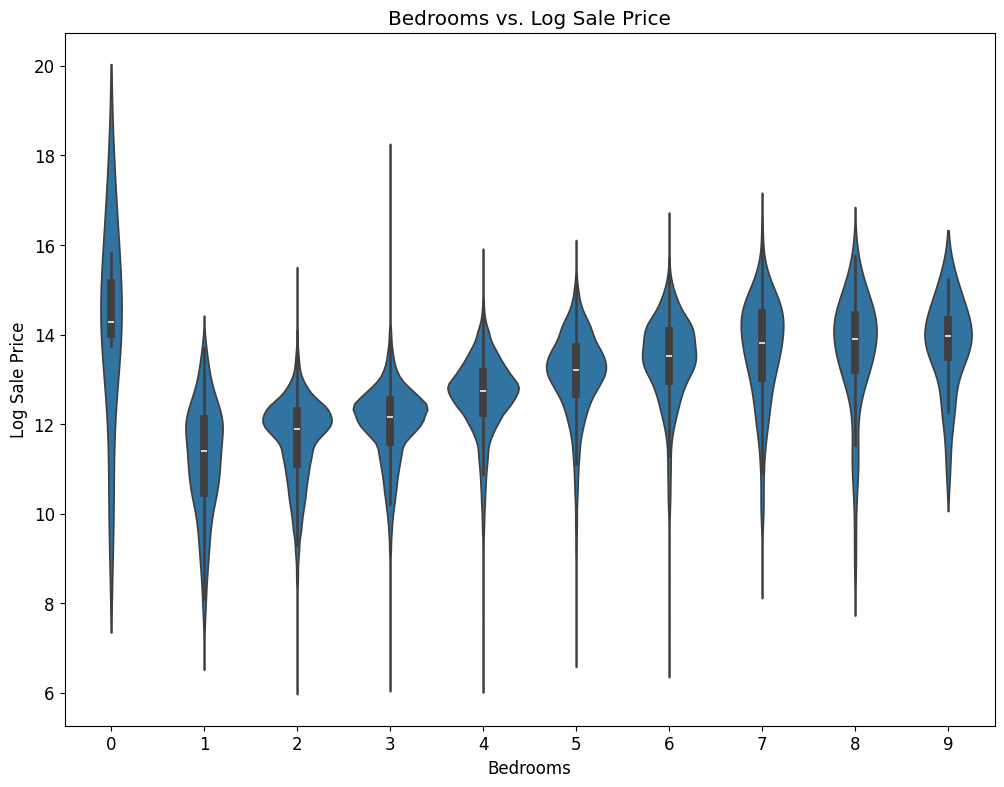

In [13]:
sns.violinplot(data=training_data,x='Bedrooms',y='Log Sale Price').set(title='Bedrooms vs. Log Sale Price')

The dataset lacks actual neighborhood names. Instead, it includes a `Neighborhood Code` column, which provides numerical encodings assigned by the Assessor's Office.

The variable `num_neighborhoods` stores the total number of unique neighborhoods in `training_data`.

In [14]:
num_neighborhoods = len(training_data['Neighborhood Code'].value_counts())
num_neighborhoods

193

Directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell results in overplotting due to the large number of neighborhoods in our dataset.

To more clearly visualize the distribution of `Log Sale Price` across neighborhoods, the focus is narrowed to a subset of neighborhoods to avoid an overly dense x-axis.

In [15]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(),
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

The variable `in_top_20_neighborhoods` is a copy of `training_data` that has been filtered to only contain rows corresponding to properties that are one of the top 20 most populous neighborhoods. The "top 20 neighborhoods" are defined as the 20 neighborhood codes that have the greatest number of properties within them.

In [16]:
top_20_neighborhood_codes = training_data['Neighborhood Code'].value_counts().index.to_list()[0:20]
in_top_20_neighborhoods = training_data.loc[training_data['Neighborhood Code'].isin(top_20_neighborhood_codes)]

The following plot visualizes the distribution of `sale price` within in each neighborhood again with the top 20 neighborhoods.

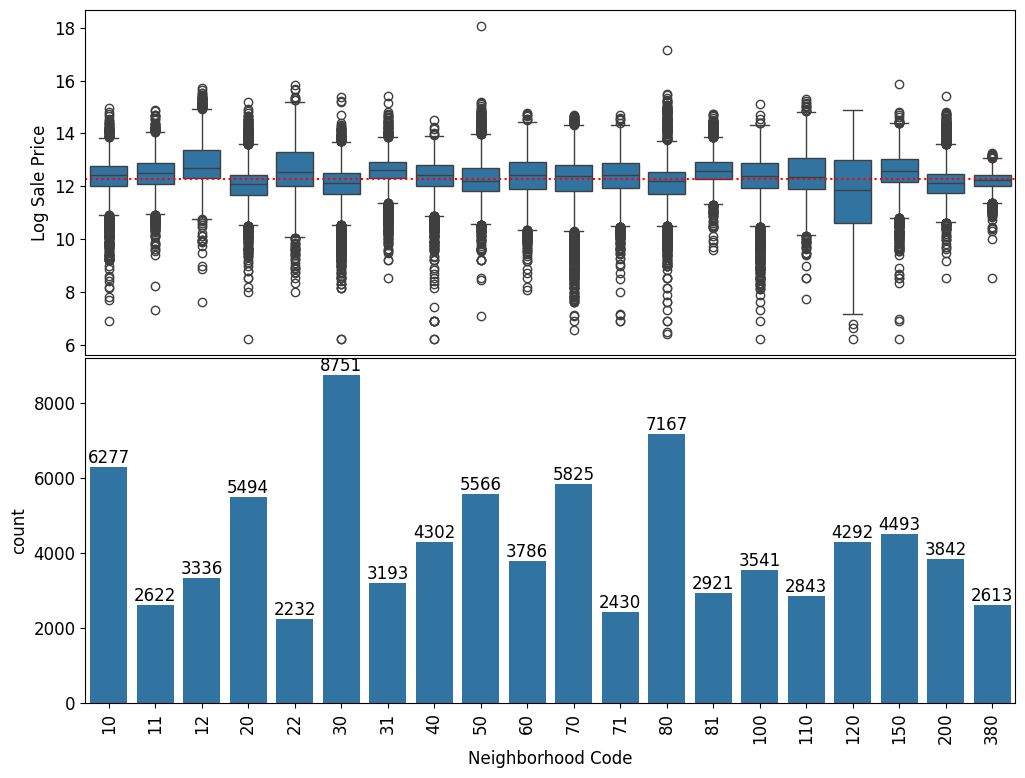

In [17]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

The plot above suggests there is much less data available for some neighborhoods. For example, Neighborhood 71 has only around 27% of the number of datapoints as Neighborhood 30.

One approach to addressing the lack of data for some neighborhoods involves creating a new feature that bins neighborhoods together. The neighborhoods are categorized by how "expensive" they are, determined by aggregating the `Log Sale Price`s for all properties in a particular neighborhood using a chosen `metric`, such as the median. The top n most expensive neighborhoods are labeled as "expensive neighborhoods" and all other neighborhoods are left unmarked.

The function `find_expensive_neighborhoods` returns a **list** of the neighborhood codes of the **top `n`** most expensive neighborhoods as measured by the aggregating function, `metric`. For example, calling `find_expensive_neighborhoods(training_data, n=3, metric=np.median)` returns the 3 neighborhood codes with the highest median `Log Sale Price` computed across all properties in those neighborhood codes.


In [18]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least a int-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices

    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods
      as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood Code')['Log Sale Price'].agg(metric).sort_values(ascending=False).iloc[0:n].index

    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

A list of neighborhoods deemed as higher-priced than others can be used to write an additional function `add_expensive_neighborhood`, which takes in a `DataFrame` of housing data (`data`) and a list of neighborhood codes considered to be expensive (`expensive_neighborhoods`).

Using these inputs, `add_expensive_neighborhood` adds a column to `data` named `in_expensive_neighborhood` that takes on the **integer** value of 1 if a property is part of a neighborhood in `expensive_neighborhoods` and the integer value of 0 if it is not.

In [19]:
def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

Examining the `Roof Material` feature of the dataset, the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column, as outlined in the `codebook.txt` file).
```
Roof Material (Nominal):

       1    Shingle/Asphalt
       2    Tar & Gravel
       3    Slate
       4    Shake
       5    Tile
       6    Other
```

The function `substitute_roof_material` replaces each numerical value in `Roof Material` with their corresponding roof material. It returns a new `DataFrame` instead of modifying the existing `DataFrame`.


In [20]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.replace({'Roof Material': {1: 'Shingle/Asphalt', 2: 'Tar & Gravel', 3: 'Slate', 4: 'Shake', 5: 'Tile', 6: 'Other'}})
    return data

training_data_mapped = substitute_roof_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0


### One Hot Encoding

Simply replacing the integers with the appropriate strings isn't sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, it must be one-hot-encoded.

The function `ohe_roof_material` returns a `DataFrame` with the new column one-hot-encoded on the roof material of the household using Scikit-learn's `OneHotEncoder`. These new columns take the form `Roof Material_MATERIAL`, and the function returns a new `DataFrame`.

In [21]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    cat = ['Roof Material']

    oh_enc = OneHotEncoder()
    oh_enc.fit(data[cat])
    ohe_data = oh_enc.transform(data[cat]).toarray()
    data_2 = (data.join(pd.DataFrame(ohe_data, columns=oh_enc.get_feature_names_out(), index=data.index)))
    data_2 = data_2.rename(columns={'Roof Material_1.0': 'Roof Material_Shingle/Asphalt',
                                    'Roof Material_2.0': 'Roof Material_Tar & Gravel',
                                    'Roof Material_3.0': 'Roof Material_Slate',
                                    'Roof Material_4.0': 'Roof Material_Shake',
                                    'Roof Material_5.0': 'Roof Material_Tile',
                                    'Roof Material_6.0': 'Roof Material_Other'})
    return data_2

training_data_ohe = ohe_roof_material(training_data)
# This line of code will display only the one-hot-encoded columns in training_data_ohe that
# have names that begin with “Roof Material_"
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Shingle/Asphalt,Roof Material_Tar & Gravel,Roof Material_Slate,Roof Material_Shake,Roof Material_Tile,Roof Material_Other
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0
10,1.0,0.0,0.0,0.0,0.0,0.0
11,1.0,0.0,0.0,0.0,0.0,0.0


# 5. Conclusion

The dataset was cleaned and transformed for improved interpretability. Outliers were removed, key features were engineered, and categorical variables were prepared using one-hot encoding. The dataset is now ready for Part 2, which will focus on building and evaluating predictive models to forecast property prices.